# Finite Difference Engine
This notebook demonstrates the use of `fd.py`.

We show two examples: hedging a vanilla put which works very well, and hedging a KO put which does not work all that well, even with 500 time steps per year.

Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


## FD Grid visuals: Vanilla

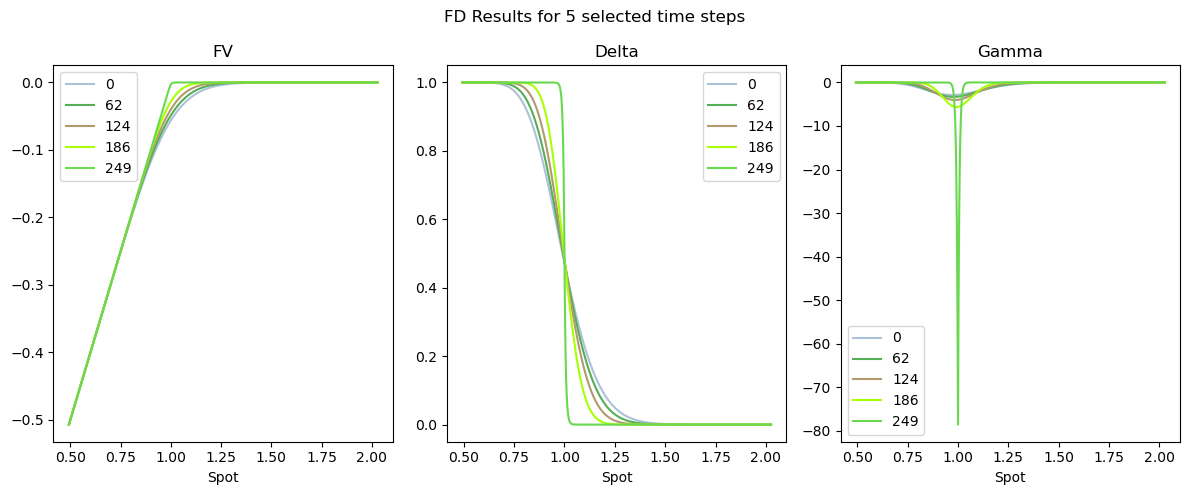

## MC pricing & FD Hedging: Vanilla

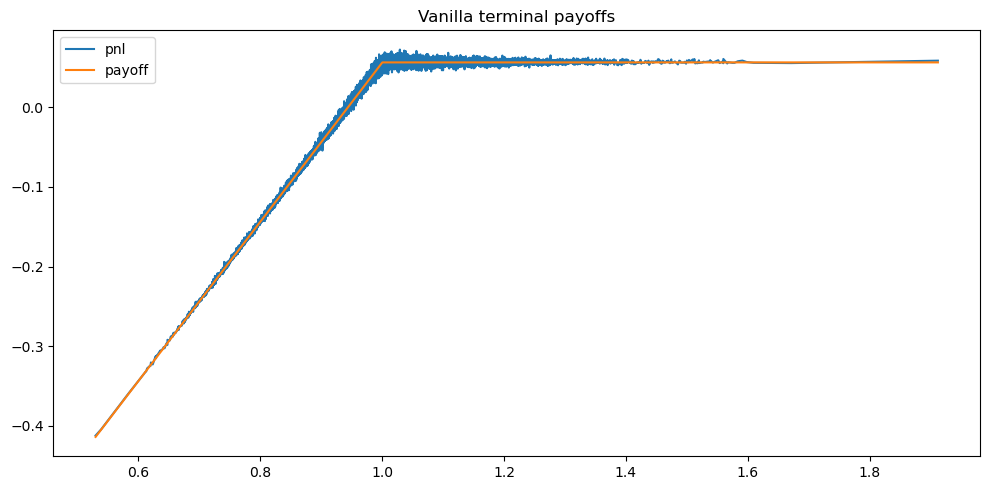

In [1]:
from deephedging.fd import bs_fd
from cdxbasics.config import Config
from cdxbasics.dynaplot import figure, colors_xkcd
import numpy as np
import math as math
from IPython.display import display, Markdown

# BlackScholes process
# --------------------

T          = 0.5    # in years
vol        = 0.2    
stepsPY    = 500   # steps per year
nSteps     = math.ceil( stepsPY*T )
dt         = T/float(nSteps+1)
sqrtDt     = math.sqrt(dt)
strike     = 1.
barrier    = 0.95
stdev      = 5.
nGrid      = 1000

nVizSteps  = 5

# define FD payoff
# ----------------

def fdKOput( X : np.ndarray, F : np.ndarray, t : float ) -> np.ndarray:
    F = - np.maximum( 0., strike - X ) if F is None else F   # terminal payoff
    return F

def mcKOput( X : np.ndarray ) -> np.ndarray:
    F = - np.maximum( 0., strike - X[:,-1] )
    return F

times = np.linspace(0.,T,nSteps+1,endpoint=True) 
spots = np.exp( np.linspace( -stdev, +stdev, 2*(nGrid//2)+1, endpoint=True ) * vol * math.sqrt(T) )
fd    = bs_fd(     spots     = [spots]*(nSteps+1),
                   times     = times, 
                   vol       = vol, 
                   payoff    = fdKOput, 
                   cn_factor = 'implicit')
assert len(fd) == nSteps+1, "Expected %ld FD results, found %ld" % (nSteps+1,len(fd))

# visualize fv, delta, gamma
# --------------------------

display(Markdown("## FD Grid visuals: Vanilla"))

ixs = np.linspace(0,nSteps-1,nVizSteps,endpoint=True,dtype=np.int32)

fig = figure(col_nums = 3)
fig.suptitle("FD Results for %ld selected time steps" % nVizSteps)
ax_fv = fig.add_subplot()
ax_dn = fig.add_subplot()
ax_gm = fig.add_subplot()
ax_fv.set_title("FV")
ax_dn.set_title("Delta")
ax_gm.set_title("Gamma")
ax_fv.set_xlabel("Spot")
ax_dn.set_xlabel("Spot")
ax_gm.set_xlabel("Spot")

colors = colors_xkcd()
bump   = vol*sqrtDt

for ix in ixs:
    color = next(colors)
    strip = fd[ix]
    dx,df = strip.fd_delta
    gx,gf = strip.fd_gamma

    ax_fv.plot( strip.X, strip.F, color=color, label="%ld" % ix)
    ax_dn.plot( dx, df, color=color, label="%ld" % ix)
    ax_gm.plot( gx, gf, color=color, label="%ld" % ix)

ax_fv.legend()
ax_dn.legend()
ax_gm.legend()
fig.render()
fig.close()

# MC
# --

display(Markdown("## MC pricing & FD Hedging: Vanilla"))

# diffuse
nSamples = 20000
spots    = np.ones((nSamples,nSteps+1))
for t in range(nSteps):
    dW    =  np.random.normal(size=(nSamples,))
    dS    =  np.exp( vol * sqrtDt * dW - 0.5 * vol * vol * dt )
    dS    /= np.mean(dS)
    spots[:,t+1] = spots[:,t] * dS
    
mc = mcKOput( spots )
assert mc.shape == (nSamples,), mc.shape
    
# hedge
pnl      = np.zeros((nSamples,))
pdelta   = np.zeros((nSamples,))
dx       = vol * sqrtDt
for t in range(nSteps):
    strip  =  fd[t]
    """
    f      =  np.interp( spots[:,t], strip.X, strip.F)
    fup    =  np.interp( spots[:,t] + dx, strip.X, strip.F)
    fdn    =  np.interp( spots[:,t] - dx, strip.X, strip.F)
    delta  =  ( fup - fdn ) / ( 2.*dx ) 
    """
    delta  =  strip.bump_delta(spots[:,t], dx)
    action =  delta - pdelta
    pnl    += action * ( spots[:,-1] - spots[:,t] )
    pdelta =  delta
    
# plot
ixs = np.argsort( spots[:,-1] )
x   = spots[ixs,-1]
mc  = ( mc - np.mean(mc) )[ixs]
pnl = pnl[ixs]

fig = figure( col_size = 10, col_nums = 1 )
ax = fig.add_subplot()
ax.set_title("Vanilla terminal payoffs")
ax.plot( x, pnl, label="pnl")
ax.plot( x, mc, label="payoff")
ax.legend()

fig.render()
fig.close()


## FD Grid visuals: KO Put

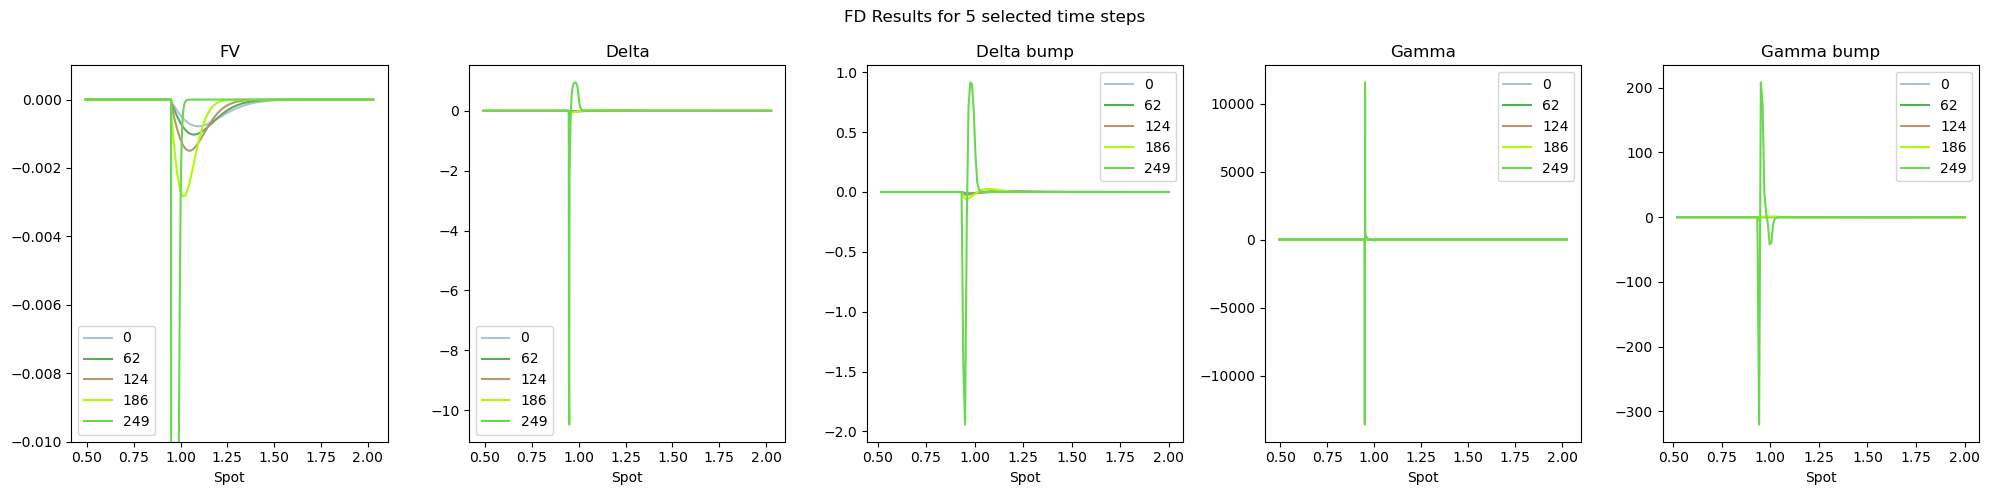

## MC pricing & FD Hedging: KO Put
The quality of the FD hedge is much diminished compared to the vanilla case. This is due to the continuous barrier.
We are using a 'bump' FD hedge in below

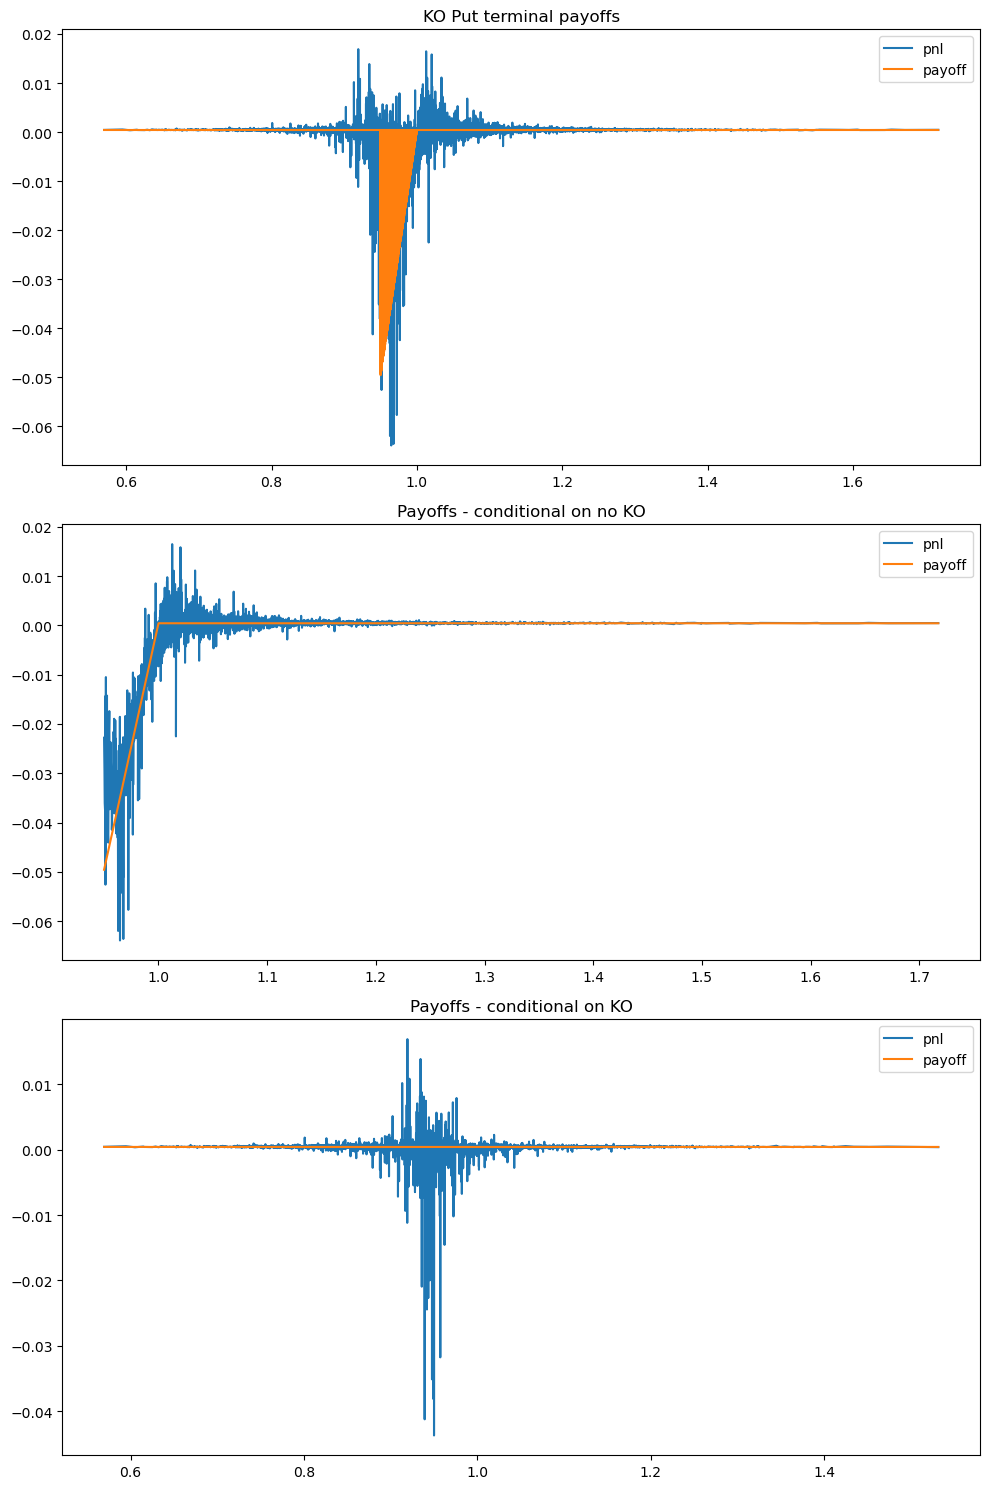

In [2]:
from deephedging.fd import bs_fd
from cdxbasics.config import Config
from cdxbasics.dynaplot import figure, colors_xkcd
import numpy as np
import math as math
from IPython.display import display, Markdown

# BlackScholes process
# --------------------

T          = 0.5    # in years
vol        = 0.2    
stepsPY    = 500   # steps per year
nSteps     = math.ceil( stepsPY*T )
dt         = T/float(nSteps+1)
sqrtDt     = math.sqrt(dt)
strike     = 1.
barrier    = 0.95
stdev      = 5.
nGrid      = 1000

nVizSteps  = 5

# define FD payoff
# ----------------

def fdKOput( X : np.ndarray, F : np.ndarray, t : float ) -> np.ndarray:
    F = - np.maximum( 0., strike - X ) if F is None else F   # terminal payoff
    F = np.where( X > barrier, F, 0. )
    return F

def mcKOput( X : np.ndarray ) -> np.ndarray:
    F = - np.maximum( 0., strike - X[:,-1] )
    F = np.where( np.min(X, axis=1) > barrier, F, 0. )
    return F

times = np.linspace(0.,T,nSteps+1,endpoint=True) 
spots = np.exp( np.linspace( -stdev, +stdev, 2*(nGrid//2)+1, endpoint=True ) * vol * math.sqrt(T) )
fd    = bs_fd(     spots     = [spots]*(nSteps+1),
                   times     = times, 
                   vol       = vol, 
                   payoff    = fdKOput, 
                   cn_factor = 'implicit')
assert len(fd) == nSteps+1, "Expected %ld FD results, found %ld" % (nSteps+1,len(fd))

# visualize fv, delta, gamma
# --------------------------

display(Markdown("## FD Grid visuals: KO Put"))

ixs = np.linspace(0,nSteps-1,nVizSteps,endpoint=True,dtype=np.int32)

fig = figure()
fig.suptitle("FD Results for %ld selected time steps" % nVizSteps)
ax_fv = fig.add_subplot()
ax_dn = fig.add_subplot()
ax_dn2 = fig.add_subplot()
ax_gm = fig.add_subplot()
ax_gm2 = fig.add_subplot()
ax_fv.set_title("FV")
ax_dn.set_title("Delta")
ax_dn2.set_title("Delta bump")
ax_gm.set_title("Gamma")
ax_gm2.set_title("Gamma bump")
ax_fv.set_xlabel("Spot")
ax_dn.set_xlabel("Spot")
ax_gm.set_xlabel("Spot")
ax_dn2.set_xlabel("Spot")
ax_gm2.set_xlabel("Spot")

colors = colors_xkcd()

for ix in ixs:
    color = next(colors)
    strip = fd[ix]
    dx,df = strip.fd_delta
    gx,gf = strip.fd_gamma
    
    xlo = strip.X[ 0]+bump*2
    xhi = strip.X[-1]-bump*2 
    nx  = math.ceil( (xhi - xlo) / bump )
    xs  = np.linspace(xlo, xhi, nx, endpoint=True)
    fs  = np.interp( xs, strip.X, strip.F )
    ds  = ( fs[2:] - fs[:-2] )/( xs[2:] - xs[:-2] )
    gs  = ( fs[2:] - 2.* fs[1:-1] + fs[:-2] ) / ((0.5*(xs[2:] - xs[:-2]))**2)
        
    ax_fv.plot( strip.X, strip.F, color=color, label="%ld" % ix)
    ax_dn.plot( dx, df, color=color, label="%ld" % ix)
    ax_gm.plot( gx, gf, color=color, label="%ld" % ix)
    ax_dn2.plot( xs[1:-1], ds, color=color, label="%ld" % ix)
    ax_gm2.plot( xs[1:-1], gs, color=color, label="%ld" % ix)

ax_fv.legend()
ax_dn.legend()
ax_gm.legend()
ax_dn2.legend()
ax_gm2.legend()
ax_fv.set_ylim(-0.01,0.001)

fig.render()
fig.close()

# MC
# --

display(Markdown("## MC pricing & FD Hedging: KO Put\n"
                 "The quality of the FD hedge is much diminished compared to the vanilla case. This is due to the continuous barrier.\n"
                 "We are using a 'bump' FD hedge in below"))

# diffuse
nSamples = 20000
spots    = np.ones((nSamples,nSteps+1))
for t in range(nSteps):
    dW    =  np.random.normal(size=(nSamples,))
    dS    =  np.exp( vol * sqrtDt * dW - 0.5 * vol * vol * dt )
    dS    /= np.mean(dS)
    spots[:,t+1] = spots[:,t] * dS
    
mc = mcKOput( spots )
assert mc.shape == (nSamples,), mc.shape
ko = np.cumprod( np.where( spots > barrier, 1., 0.), axis=1 )
    
# hedge
pnl      = np.zeros((nSamples,))
pdelta   = np.zeros((nSamples,))
dx       = vol * sqrtDt
for t in range(nSteps):
    strip  =  fd[t]
    delta  =  strip.bump_delta( spots[:,t], dx )
    delta  =  ko[:,t] * delta
    action =  delta - pdelta
    pnl    += action * ( spots[:,-1] - spots[:,t] )
    pdelta =  delta
    
# plot
ixs = np.argsort( spots[:,-1] )
x   = spots[ixs,-1]
mc  = ( mc - np.mean(mc) )[ixs]
pnl = pnl[ixs]
koT = ko[ixs,-1]

fig = figure( col_size = 10, col_nums = 1 )
ax = fig.add_subplot()
ax.set_title("KO Put terminal payoffs")
ax.plot( x, pnl, label="pnl")
ax.plot( x, mc, label="payoff")
ax.legend()

nokoixs = koT > 0.

ax = fig.add_subplot()
ax.set_title("Payoffs - conditional on no KO")
ax.plot( x[nokoixs], pnl[nokoixs], label="pnl")
ax.plot( x[nokoixs], mc[nokoixs], label="payoff")
ax.legend()
koixs = koT < 1.

ax = fig.add_subplot()
ax.set_title("Payoffs - conditional on KO")
ax.plot( x[koixs], pnl[koixs], label="pnl")
ax.plot( x[koixs], mc[koixs], label="payoff")
ax.legend()

fig.render()
fig.close()
